In [1]:
# import cv2
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping
from keras import backend as keras
from PIL import Image,ImageDraw
from matplotlib.patches import Circle

import random
# from skimage import filters,img_as_float
# from skimage.io import imsave

In [2]:
import matplotlib.pyplot as plt

In [3]:
import xml.etree.ElementTree as ET
import os
images_train={}
for filename in os.listdir('fracture/training/'):
    img1=Image.open(os.path.join('fracture/training/', filename)).convert('RGB')
    index=os.path.splitext(filename)[0]
    images_train[index]=img1


image_train_annotations={}
for filename in os.listdir('fracture/training_annotations/'):
    tree=ET.parse(os.path.join('fracture/training_annotations/', filename))
    root=tree.getroot()
    index_=os.path.splitext(filename)[0]
    img=images_train[index_]
    width,height=img.size
    if img == None:
        del images_train[index_]
        continue
    image=Image.new(mode='1',size=(width,height),color=0)
    image1=Image.new(mode='1',size=(width,height),color=1)
    try:
        for objects in root.iter('bndbox'):
            start1,end1=(int(objects.find('xmin').text),int(objects.find('ymin').text))
            start2,end2=(int(objects.find('xmax').text),int(objects.find('ymax').text))
            image1=image1.crop((start1,end1,start2,end2))
            image.paste(image1,(start1,end1,start2,end2))
        image_train_annotations[index_]=image
    except AttributeError:
        del images_train[index_]

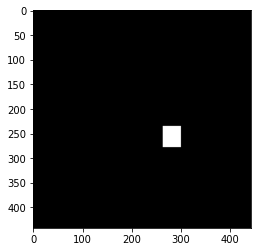

In [4]:
plt.imshow(image_train_annotations['1'])

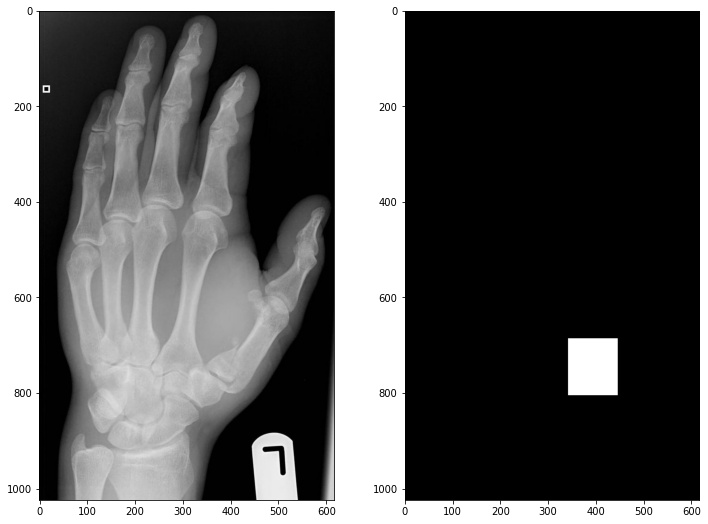

In [5]:
fn = lambda x : 1 if x > 240 else 0
train_data=[images_train[i] for i in sorted(images_train)]
train_annotations=[image_train_annotations[i] for i in sorted(image_train_annotations)]

fig, axs = plt.subplots(1,2, figsize = (12, 9))
axs[0].imshow(train_data[0])

plt.imshow(train_annotations[0])

In [6]:
images_valid={}
for filename in os.listdir('fracture/validation/'):
    # for filename in filenames:
    img1=Image.open(os.path.join('fracture/validation/', filename)).convert('RGB')
    index=os.path.splitext(filename)[0]
    images_valid[index]=img1
#axs[0].imshow(images_train['0'])

image_valid_annotations={}

for filename in os.listdir('fracture/validation_annotations/'):
    # for filename in filenames:
    tree=ET.parse(os.path.join('fracture/validation_annotations/', filename))
    root=tree.getroot()
    index_=os.path.splitext(filename)[0]
    img=images_valid[index_]
    width,height=img.size
    #print(width,height,type(img))
    if img == None:
        del images_train[index_]
        continue
    image=Image.new(mode='1',size=(width,height),color=0)
    image1=Image.new(mode='1',size=(width,height),color=1)
    #print(type(image))
    try:
        for objects in root.iter('bndbox'):
            start1,end1=(int(objects.find('xmin').text),int(objects.find('ymin').text))
            start2,end2=(int(objects.find('xmax').text),int(objects.find('ymax').text))
            #print(start1,end1,start2,end2)
            image1=image1.crop((start1,end1,start2,end2))
            image.paste(image1,(start1,end1,start2,end2))
            #print(type(image))
        image_valid_annotations[index_]=image
    except AttributeError:
        del images_train[index_]
    #print(image)
#plt.imshow(image_valid_annotations['1'])

In [7]:
data_train = (images_train | images_valid)
data_mask = image_train_annotations | image_valid_annotations

In [8]:
# img = data_train[key].resize((256,256))
#         img = np.array(img)

In [9]:
data_train = np.array([np.array(data_train[key].resize((256,256))) for key in sorted(list(data_train.keys()))])
data_mask = np.array([np.array(data_mask[key].resize((256,256))) for key in sorted(list(data_mask.keys()))])

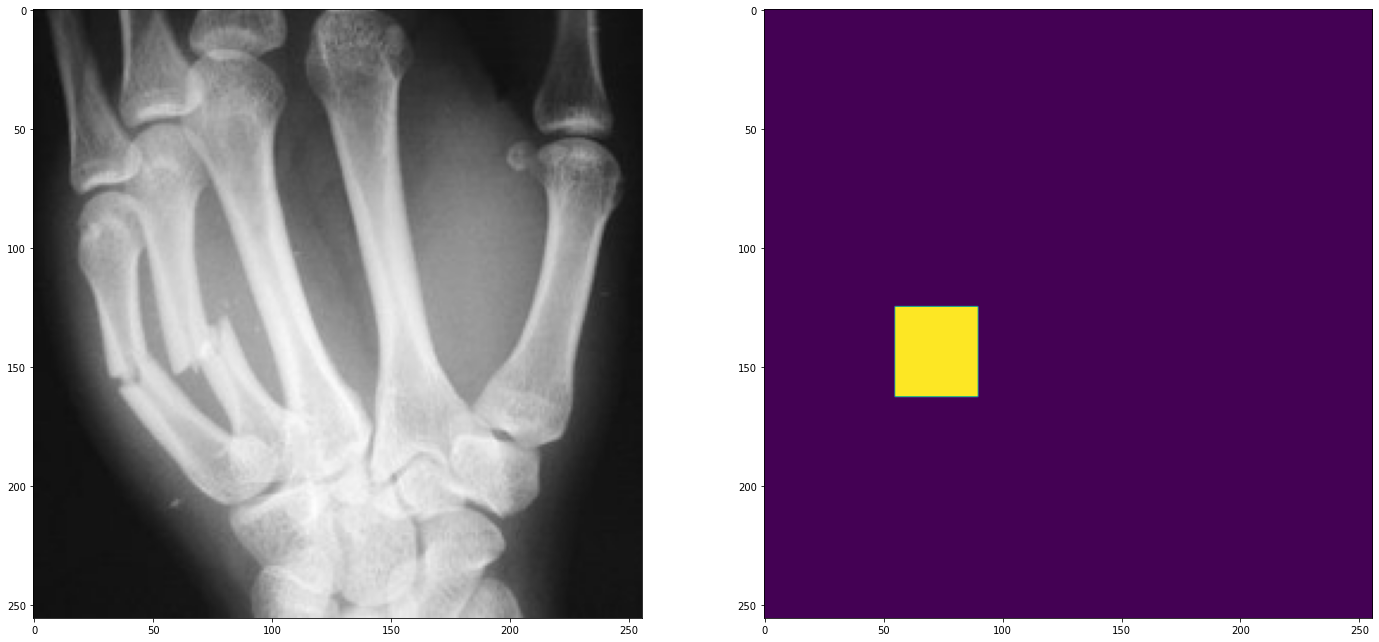

In [10]:
x = random.randint(0, len(data_train))
plt.figure(figsize=(24,18))
plt.subplot(1,2,1)
plt.imshow(data_train[x])
plt.subplot(1,2,2)
plt.imshow(data_mask[x])
plt.show()

In [11]:
data_mask.shape

(237, 256, 256)

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
nsamples, nx, ny, nz = data_train.shape
d2_data_train = data_train.reshape((nsamples,nx*ny*nz))
train_images = scaler.fit_transform(d2_data_train)
train_images = train_images.reshape(237,256,256,3)

# Multihot vectorization of the labels

In [13]:
# def multihot_vectorization(label):
#     image_labels = np.zeros(label.shape, dtype=np.uint8)
#     for i in range(24):
#         image_labels [np.all(label == labels[i,:],axis=-1)] = i
#     image_labels = image_labels[:,:,0]
#     return image_labels
    

# label_final = []
# for i in range(data_mask.shape[0]):
#     label = multihot_vectorization(data_mask[i])
#     label_final.append(label)    

label_final = np.array(data_mask)  

# Create the training dataset

In [14]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


n_classes = len(np.unique(label_final))
labels_cat = to_categorical(label_final, num_classes=n_classes)
x_train, x_test, y_train, y_test = train_test_split(train_images, labels_cat, test_size = 0.20, random_state = 42)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

In [16]:
def encoder(inputs):
    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv_1 = Dropout(0.1)(conv_1)  
    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1)
    pool_1 = MaxPooling2D((2, 2))(conv_1)
    
    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_1)
    conv_2 = Dropout(0.1)(conv_2)  
    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_2)
    pool_2 = MaxPooling2D((2, 2))(conv_2)
     
    conv_3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_2)
    conv_3 = Dropout(0.1)(conv_3)
    conv_3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_3)
    pool_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
     
    conv_4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_3)
    conv_4 = Dropout(0.2)(conv_4)
    conv_4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_4)
    return conv_4, conv_3, conv_2, conv_1


def decoder(conv_4, conv_3, conv_2, conv_1):
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv_4)
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    conv_6 = Dropout(0.2)(conv_6)
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_6)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv_6)
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    conv_8 = Dropout(0.2)(conv_8)  
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv_8)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    conv_9 = Dropout(0.1)(conv_9)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_9)
    return conv_9

In [17]:
def encoder_decoder_simple(n_classes=2, height=256, width=256, channels=3):
    inputs = Input((height, width, channels))

    # Encoding Path
    conv_4, conv_3, conv_2, conv_1 = encoder(inputs)
    
    # Decoding Path
    decoded = decoder(conv_4, conv_3, conv_2, conv_1)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(decoded)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Compile the model and get summary

In [21]:
img_height = x_train.shape[1]
img_width  = x_train.shape[2]
img_channels = x_train.shape[3]


metrics=['accuracy']

model = encoder_decoder_simple(n_classes=n_classes, height=img_height, 
                           width=img_width, channels=img_channels)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 dropout_7 (Dropout)         (None, 256, 256, 16)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 32)      4640      
                                                           

# Fit the model

In [22]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

In [23]:
history = model.fit(x_train, y_train, 
                    batch_size = 10, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(x_test, y_test), 
                    shuffle=False,
                    callbacks = [callback])

Epoch 1/17


2022-07-27 20:15:41.775693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.9195

2022-07-27 20:15:51.101340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 10s 473ms/step - loss: 0.2895 - accuracy: 0.9195 - val_loss: 0.1181 - val_accuracy: 0.9810
Epoch 2/17
19/19 [==============================] - 9s 467ms/step - loss: 0.0940 - accuracy: 0.9845 - val_loss: 0.0912 - val_accuracy: 0.9810
Epoch 3/17
19/19 [==============================] - 9s 460ms/step - loss: 0.0740 - accuracy: 0.9845 - val_loss: 0.0836 - val_accuracy: 0.9810
Epoch 4/17
19/19 [==============================] - 8s 441ms/step - loss: 0.0702 - accuracy: 0.9845 - val_loss: 0.0824 - val_accuracy: 0.9810
Epoch 5/17
19/19 [==============================] - 9s 494ms/step - loss: 0.0692 - accuracy: 0.9845 - val_loss: 0.0820 - val_accuracy: 0.9810
Epoch 6/17
19/19 [==============================] - 9s 482ms/step - loss: 0.0685 - accuracy: 0.9845 - val_loss: 0.0820 - val_accuracy: 0.9810
Epoch 7/17
19/19 [==============================] - 9s 485ms/step - loss: 0.0678 - accuracy: 0.9845 - val_loss: 0.0809 - val_accuracy: 0.9810
Epoch 8/17
19/19

In [24]:
model.save('/Volumes/GoogleDrive/My Drive/Personal Project/Bone-Fracture-Detection/fracture_detection_encoder_decoder_model.hdf5')

# Visualize the performance of the model

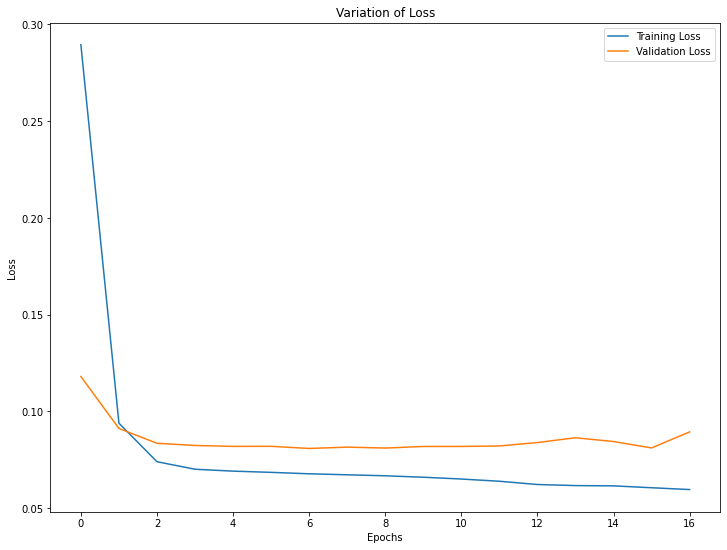

In [25]:
plt.figure(figsize = (12, 9))

plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Variation of Loss')
plt.legend()

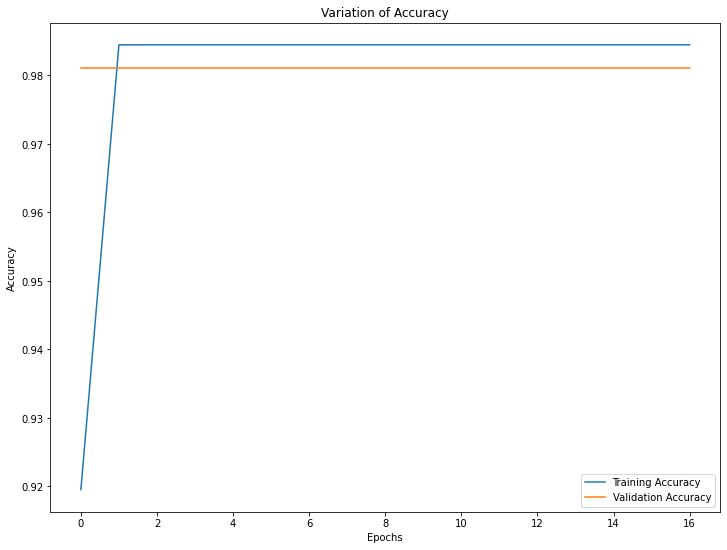

In [26]:
plt.figure(figsize = (12, 9))

plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Variation of Accuracy')
plt.legend()

# Now I will visualise some predictions against the ground truth

1/1 [==============================] - 0s 18ms/step


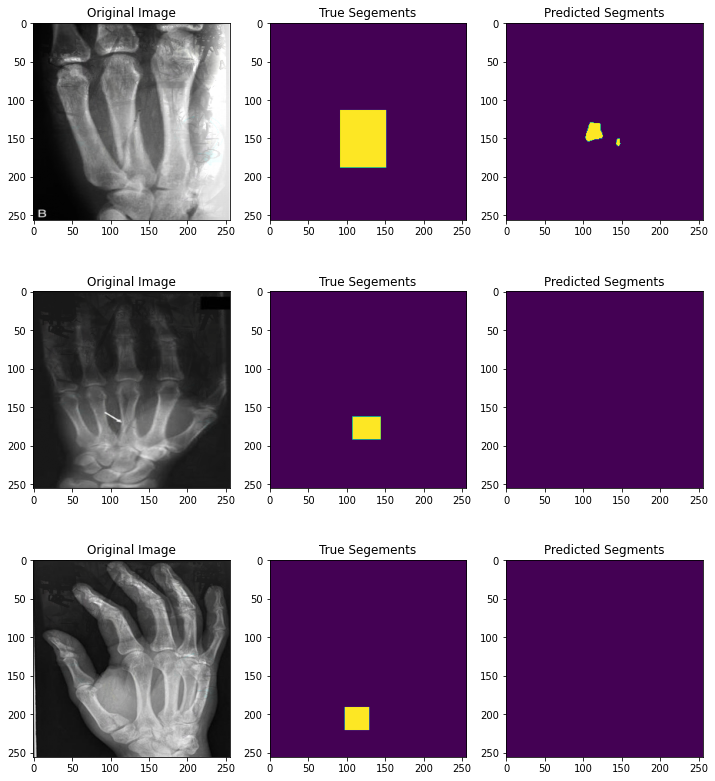

In [98]:
y_pred=model.predict(x_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

fig, axes = plt.subplots(3, 3, figsize = (12,14))
for i in range(3):
    random_index = random.randint(0, len(x_test))
    img = x_test[random_index]
    y_true = y_test_argmax[random_index] 
    test_img_input = np.expand_dims(img, 0) 
    img_pred = np.argmax(model.predict(test_img_input), axis=3)[0,:,:] 
    vals = [img, y_true, img_pred]
    labels_vals = ["Original Image", "True Segements", "Predicted Segments"]
    for j in range(3):   
        
        axes[i,j].imshow(vals[j])
        axes[i,j].set_title(labels_vals[j])
    
plt.show()

In [99]:
import keras
model_loded = keras.models.load_model('/Volumes/GoogleDrive/My Drive/Personal Project/Bone-Fracture-Detection/fracture_segmentation_model.hdf5', custom_objects = {'jacard': jacard_loss})

In [100]:
model_loded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

(10,)
1/1 [==============================] - 0s 78ms/step
143 150 193 200
1/1 [==============================] - 0s 13ms/step
143 150 193 200
1/1 [==============================] - 0s 15ms/step
146 160 208 213
1/1 [==============================] - 0s 15ms/step
146 160 208 213
1/1 [==============================] - 0s 21ms/step
107 112 40 62
1/1 [==============================] - 0s 34ms/step
170 184 139 160
1/1 [==============================] - 0s 18ms/step
170 184 139 160
1/1 [==============================] - 0s 20ms/step
121 126 196 208
1/1 [==============================] - 0s 14ms/step
121 126 196 208
1/1 [==============================] - 0s 17ms/step
121 126 196 208


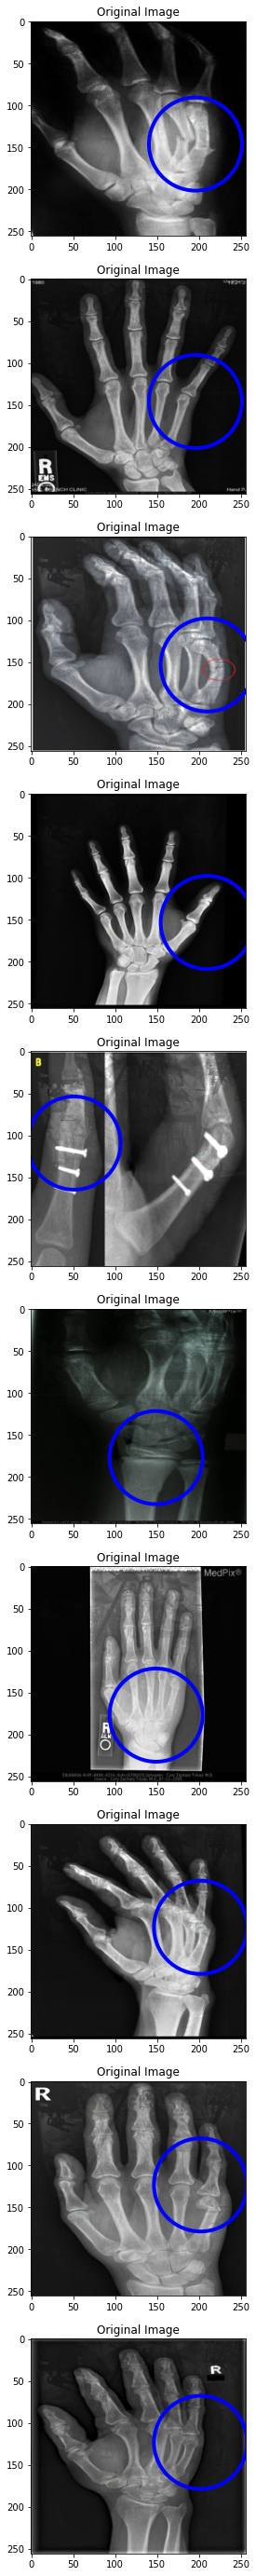

In [171]:
# y_pred=model_loded.predict(x_test)
# y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

fig, axes = plt.subplots(10, 1, figsize = (50, 50))
fract_locations = []
print(axes.shape)
for i in range(10):
    random_index = random.randint(0, len(x_test)-1)
    img = x_test[random_index]
    y_true = y_test_argmax[random_index] 
    test_img_input = np.expand_dims(img, 0) 
    img_pred = np.argmax(model_loded.predict(test_img_input), axis=3)[0,:,:]

    for j in range(img_pred.shape[0]):
        if img_pred[j, :].sum() != 0:
            # print(f'X0 = {j}')
            x0 = j
            break

    for j in range(img_pred.shape[0]-1, -1, -1):
        if img_pred[j, :].sum() != 0:
            # print(f'X1 = {j}')
            x1 = j
            break
    
    for j in range(img_pred.shape[1]):
        if img_pred[:, j].sum() != 0:
            # print(f'Y0 = {j}')
            y0 = j
            break

    for j in range(img_pred.shape[1]-1, -1, -1):
        if img_pred[:, j].sum() != 0:
            # print(f'Y1 = {j}')
            y1 = j
            break

    img_pred[x0, :] = 1
    img_pred[x1, :] = 1
    img_pred[:, y0] = 1
    img_pred[:, y1] = 1
    c1 = (x0 + x1)//2
    c2 = (y0 + y1)//2
    img_pred[:, c2] = 1
    img_pred[c1, :] = 1
    # fract_locations.append()
    print(x0, x1, y0, y1)
    
    vals = [img, y_true, img_pred]
    labels_vals = ["Original Image", "True Segements", "Predicted Segments"]
    for j in range(0, 1):   
        # print((x0 + x1)//2, (y0 + y1)//2)
        axes[i].imshow(img)
        axes[i].set_title(labels_vals[j])
        # circ = Circle((c2, c1), 50, )
        axes[i].scatter( c2, c1 , s=10000 ,  facecolors='none', edgecolors='blue', linewidth = 4) 
        # axes[i].add_patch(circ)
    
plt.show()